In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
request_df = pd.read_csv("2023requests.csv")

/var/folders/08/jl8s46nj1937wqfyst1xgq080000gn/T/ipykernel_886/3278231074.py:1: DtypeWarning: Columns (8,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv("2023requests.csv")


In [3]:
requestdf = request_df.copy()

In [4]:
pd.set_option("display.max_rows", 200)

In [5]:
#around half of all missing lat/long strings are also missing community board, meaning only borough is included,
requestdf.loc[requestdf["Latitude"].isna()]["Community Board"].str.startswith("Unspecified").sum()/requestdf.loc[requestdf["Latitude"].isna()]["Community Board"].shape[0]

0.4722052535125229

Removing requests with no location data, mostly information requests which could be used outside of creating the map if necessary.

In [6]:
print(requestdf["Longitude"].isna().sum(),requestdf["Latitude"].isna().sum())
print(requestdf.shape[0])
requestdf = requestdf.drop(index=requestdf.loc[requestdf["Longitude"].isna()].index)
print(requestdf.shape[0])

49110 49110
3225193
3176083


Removes un-needed columns, with explanation why each was removed. Some may be useful for other analysis objectives.

In [7]:
#List of un-needed columns to drop to improve speed on current project
dropcolumns = ["Location Type", #specifies exact type of location, not used since only using lat-long
               "Incident Zip", "Incident Address", "Street Name", "Cross Street 1", "Cross Street 2", "Intersection Street 1", "Intersection Street 2", "Address Type", "City", #lat-long used instead of all up to Facility Type
               "Landmark", #closest landmark, not needed
               "Facility Type", #only DSNY Garage non-na, not needed
               "Due Date", #may be helpful for other analysis but not here
               "Resolution Description", #USEFUL FOR TEXT ANALYSIS IF USING
               "Resolution Action Updated Date", #not super relevant, also confusing without info into operations
               "BBL", #mostly missing, also replaced by lat-long
               "X Coordinate (State Plane)", "Y Coordinate (State Plane)", #not sure of use, also likely replaced by lat-long
               "Open Data Channel Type", #MAY BE NEAT FOR VIZUALING, medium of request
               "Park Facility Name", "Park Borough", #not needed due to lat-long
               "Vehicle Type", #may be useful if going in depth on vehicle requests
               "Taxi Company Borough", "Taxi Pick Up Location", #not needed
               "Bridge Highway Name", "Road Ramp", "Bridge Highway Segment", "Bridge Highway Direction", #not needed unless super specific wanted
               "Location", #lat-long combined,
               "Borough Boundaries", #just numerical of borough 1-5,
               "Police Precincts", #duplicate
               ]

requestdf = requestdf.drop(columns=dropcolumns)

In [8]:
requestdf.isna().sum()

Unique Key                     0
Created Date                   0
Closed Date               127209
Agency                         0
Agency Name                    0
Complaint Type                 0
Descriptor                 96765
Status                         0
Community Board                0
Borough                        0
Latitude                       0
Longitude                      0
Zip Codes                  12338
Community Districts          682
City Council Districts       682
Police Precinct              664
dtype: int64

In [91]:
#replaces duplicate complaints
requestdf["Complaint Type"] = requestdf["Complaint Type"].replace(["PLUMBING", "HEAT/HOT WATER", "OUTSIDE BUILDING", "DOOR/WINDOW", "ELECTRIC", "GENERAL", "PAINT/PLASTER", "Peeling Paint", "UNSANITARY CONDITION", "FLOORING/STAIRS", "WATER LEAK", "SAFETY", "APPLIANCE", "ELEVATOR"],
                                                                  ["Plumbing", "Heat/Hot Water", "Outside Building", "Door/Window", "Electric", "General", "Paint/Plaster", "Paint/Plaster", "Unsanitary Condition", "Flooring/Stairs", "Water Leak", "Safety", "Appliance", "Elevator"])
requestdf["Complaint Type"] = requestdf["Complaint Type"].replace(["Mold", "Special Projects Inspection Team (SPIT)", ]
                                                                  ["Unsanitary Condition", "Building Code Violation"])

In [166]:
top50 = requestdf.loc[requestdf["Complaint Type"].isin(requestdf["Complaint Type"].value_counts().head(50).index)].copy()

In [161]:
top50.loc[top50["Complaint Type"] == "Appliance"]["Agency Name"].unique()

array(['Department of Housing Preservation and Development'], dtype=object)

In [167]:
top50["Complaint Type"].unique()
#assigning each of the top 50 complaints to a category, Adapted from categories used at https://portal.311.nyc.gov/report-problems/
categories = {'Noise - Street/Sidewalk':'Noise', 'Noise - Helicopter':'Noise',
            'Blocked Driveway':'Transportation', 'Illegal Parking':'Transportation', 'Noise - Residential':'Noise',
            'Heat/Hot Water':'Utilities', 'Noise - Commercial':'Noise', 'Sidewalk Condition':'Sidewalks, Streets & Highways',
            'Abandoned Vehicle':'Transportation', 'New Tree Request':'Environment', 'Door/Window':'Housing & Buildings', 'Electric':'Utilities',
            'Water System':'Utilities', 'Sewer':'Utilities', 'Plumbing':'Utilities', 'Non-Emergency Police Matter':'Public Safety',
            'Noise - Vehicle':'Noise', 'Noise':'Noise', 'Consumer Complaint':'Businesses & Consumers',
            'Traffic Signal Condition':'Sidewalks, Streets & Highways', 'Building/Use':'Housing & Buildings', 'General':'Misc',
            'Dirty Condition':'Trash & Recycling', 'Rodent':'Health', 'Obstruction':'Sidewalks, Streets & Highways', 'Illegal Dumping':'Public Safety',
            'Paint/Plaster':'Housing & Buildings', 'Unsanitary Condition':'Health', 'Flooring/Stairs':'Housing & Buildings',
            'General Construction/Plumbing':'Housing & Buildings', 'Street Light Condition':'Sidewalks, Streets & Highways',
            'Food Establishment':'Businesses & Consumers', 'Water Leak':'Utilities', 'Damaged Tree':'Environment', 'Safety':'Health',
            'Missed Collection':'Trash & Recycling', 'Street Condition':'Sidewalks, Streets & Highways', 'Vendor Enforcement':'Businesses & Consumers',
            'Graffiti':'Misc', 'Elevator':'Housing & Buildings', 'Residential Disposal Complaint':'Trash & Recycling',
            'Drug Activity':'Public Safety', 'Appliance':'Housing & Buildings', 'Air Quality':'Environment', 'Encampment':'Misc',
            'For Hire Vehicle Complaint':'Misc', 'Overgrown Tree/Branches':'Environment',
            'Maintenance or Facility':'Housing & Buildings', 'Homeless Person Assistance':'Misc',
            'Derelict Vehicles':'Transportation'}
top50["Complaint Category"] = top50["Complaint Type"].map(categories)

In [171]:
top50["Complaint Category"].unique()

array(['Noise', 'Transportation', 'Utilities',
       'Sidewalks, Streets & Highways', 'Environment',
       'Housing & Buildings', 'Public Safety', 'Businesses & Consumers',
       'Misc', 'Trash & Recycling', 'Health'], dtype=object)

In [172]:
top50.head(5)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Status,Community Board,Borough,Latitude,Longitude,Zip Codes,Community Districts,City Council Districts,Police Precinct,Request Time,Request Hours,Request Minutes,Complaint Category
4,59889383,2023-12-31 23:59:42,2024-01-01 01:51:01,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Closed,06 QUEENS,QUEENS,40.734695,-73.850521,14786.0,40.0,28.0,70.0,0 days 01:51:19,1.0,51.0,Noise
5,59887573,2023-12-31 23:59:39,2024-01-19 14:37:37,EDC,Economic Development Corporation,Noise - Helicopter,Other,Closed,07 MANHATTAN,MANHATTAN,40.777201,-73.976159,12420.0,20.0,19.0,12.0,18 days 14:37:58,446.0,37.0,Noise
6,59892892,2023-12-31 23:59:29,2024-01-01 04:06:24,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Closed,07 QUEENS,QUEENS,40.759286,-73.822614,14190.0,22.0,3.0,67.0,0 days 04:06:55,4.0,6.0,Transportation
7,59893860,2023-12-31 23:59:29,2024-01-01 01:51:32,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Closed,06 QUEENS,QUEENS,40.729379,-73.855433,14785.0,40.0,28.0,70.0,0 days 01:52:03,1.0,52.0,Noise
8,59887231,2023-12-31 23:59:23,2024-01-01 00:13:30,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Closed,12 BROOKLYN,BROOKLYN,40.644725,-73.997622,13515.0,2.0,7.0,39.0,0 days 00:14:07,0.0,14.0,Noise


Lots of entries with missing closing date, below is a graph of the most commonly unclosed requests.

Text(0.5, 1.0, 'Top 10 Unclosed Complaints')

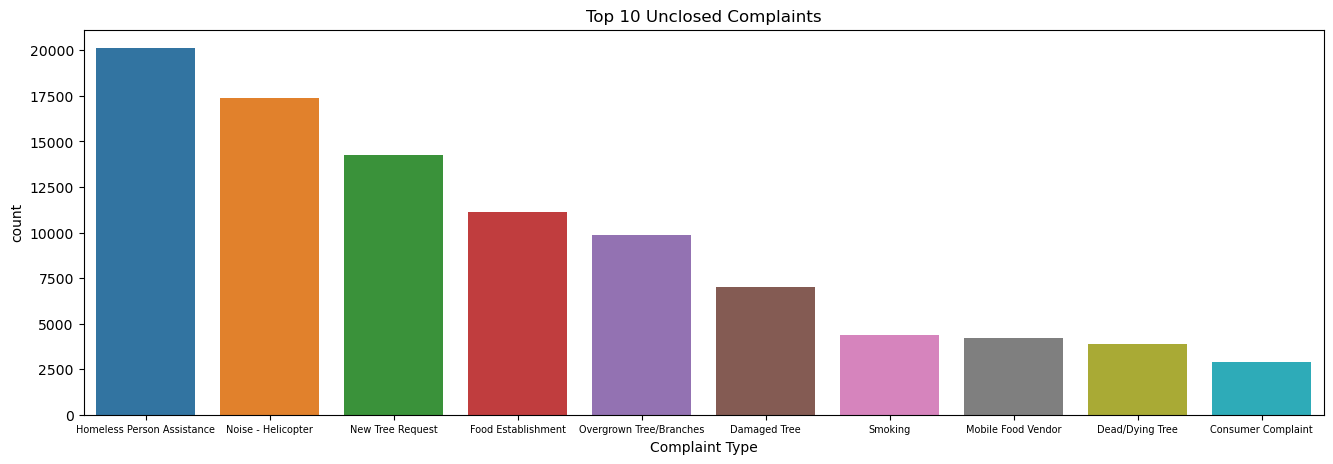

In [9]:
notclosed = requestdf.loc[requestdf["Closed Date"].isna()]
plt.figure(figsize=(16,5))
sns.countplot(data=notclosed, x="Complaint Type", order=notclosed["Complaint Type"].value_counts().iloc[:10].index)
plt.xticks(fontsize=7, rotation=0)
plt.title("Top 10 Unclosed Complaints")

Non-closed requests for things besides actionable items, ex. **New Tree Request**, may be due to a request not needing resolution like **Noise-Helicopter**. These requests will still be included in overall count since they are requests despite not being closed, and will just not have a time to resolve when calculated.

In [179]:
requestdf.head(5)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Status,Community Board,Borough,Latitude,Longitude,Zip Codes,Community Districts,City Council Districts,Police Precinct,Request Time,Request Hours,Request Minutes
0,59898042,2024-01-01 00:00:00,2024-01-02 09:24:45,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Closed,11 BRONX,BRONX,40.845340,-73.865594,11271.0,59.0,22.0,32.0,1 days 09:24:45,33.0,24.0
1,59899838,2024-01-01 00:00:00,2024-01-02 09:42:25,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Closed,06 MANHATTAN,MANHATTAN,40.759192,-73.962290,12419.0,71.0,1.0,9.0,1 days 09:42:25,33.0,42.0
2,59894610,2024-01-01 00:00:00,2024-01-02 09:46:32,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Closed,01 STATEN ISLAND,STATEN ISLAND,40.628828,-74.074387,10691.0,4.0,13.0,74.0,1 days 09:46:32,33.0,46.0
3,59896272,2024-01-01 00:00:00,2024-01-02 00:00:01,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Closed,01 BROOKLYN,BROOKLYN,40.710675,-73.954050,17613.0,36.0,30.0,56.0,1 days 00:00:01,24.0,0.0
4,59889383,2023-12-31 23:59:42,2024-01-01 01:51:01,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Closed,06 QUEENS,QUEENS,40.734695,-73.850521,14786.0,40.0,28.0,70.0,0 days 01:51:19,1.0,51.0


In [12]:
#converts dates from str into datetime format
requestdf["Created Date"] = pd.to_datetime(requestdf["Created Date"], format="%m/%d/%Y %I:%M:%S %p")
requestdf["Closed Date"] = pd.to_datetime(requestdf["Closed Date"], format="%m/%d/%Y %I:%M:%S %p")

In [40]:
#creates requesttime as timedelta of time from request open to close
requestdf["Request Time"] = requestdf["Closed Date"] - requestdf["Created Date"]
#creates new columns of hours and minutes integers from timedelta
requestdf["Request Hours"] = requestdf["Request Time"].dt.total_seconds() // 3600
requestdf["Request Minutes"] = (requestdf["Request Time"].dt.total_seconds() % 3600) // 60
#null values still exist, leave for now to not effect average

In [177]:
#lists complaint types with the longest median(instead of mean due to outliers) times to close.
top50[["Complaint Type", "Request Time"]].groupby(by="Complaint Type").mean().sort_values(by="Request Time", ascending=False)

,Request Time
Complaint Type,
New Tree Request,110 days 15:49:16
For Hire Vehicle Complaint,68 days 22:56:04
Graffiti,60 days 00:04:16
Building/Use,54 days 23:18:23
Overgrown Tree/Branches,52 days 18:36:18
Maintenance or Facility,48 days 14:06:05
Noise - Helicopter,44 days 22:46:07
Elevator,35 days 08:16:06
Damaged Tree,33 days 11:25:17


In [199]:
top50.loc[top50["Request Hours"] == top50["Request Hours"].max()]
top50.sort_values(by="Request Hours", ascending=False).head(5)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Status,Community Board,Borough,Latitude,Longitude,Zip Codes,Community Districts,City Council Districts,Police Precinct,Request Time,Request Hours,Request Minutes,Complaint Category
3199052,56437777,2023-01-04 14:36:40,2024-05-01 08:07:46,DPR,Department of Parks and Recreation,Maintenance or Facility,Garbage or Litter,Closed,11 QUEENS,QUEENS,40.761288,-73.777346,14196.0,26.0,20.0,69.0,482 days 17:31:06,11585.0,31.0,Housing & Buildings
3196736,56444013,2023-01-04 20:23:15,2024-04-30 11:51:59,DPR,Department of Parks and Recreation,Maintenance or Facility,Rodent Sighting,Closed,02 QUEENS,QUEENS,40.747087,-73.922417,16858.0,53.0,33.0,66.0,481 days 15:28:44,11559.0,28.0,Housing & Buildings
3177552,56468047,2023-01-07 09:03:45,2024-05-01 10:11:25,DPR,Department of Parks and Recreation,Maintenance or Facility,Garbage or Litter,Closed,12 QUEENS,QUEENS,40.692542,-73.795865,24668.0,41.0,46.0,61.0,480 days 01:07:40,11521.0,7.0,Housing & Buildings
3188688,56451948,2023-01-05 19:17:00,2024-04-29 00:01:00,DOT,Department of Transportation,Traffic Signal Condition,Foundation,Closed,14 BROOKLYN,BROOKLYN,40.637627,-73.955697,13510.0,60.0,11.0,43.0,479 days 04:44:00,11500.0,44.0,"Sidewalks, Streets & Highways"
3174975,56467323,2023-01-07 15:29:54,2024-04-30 11:52:02,DPR,Department of Parks and Recreation,Maintenance or Facility,Rodent Sighting,Closed,02 QUEENS,QUEENS,40.747087,-73.922417,16858.0,53.0,33.0,66.0,478 days 20:22:08,11492.0,22.0,Housing & Buildings


In [174]:
top50.loc[top50["Complaint Type"] == "Rodent"]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Status,Community Board,Borough,Latitude,Longitude,Zip Codes,Community Districts,City Council Districts,Police Precinct,Request Time,Request Hours,Request Minutes,Complaint Category
287,59893776,2023-12-31 23:05:41,2023-12-31 23:05:41,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Closed,03 BROOKLYN,BROOKLYN,40.683855,-73.951646,17618.0,69.0,49.0,51.0,0 days 00:00:00,0.0,0.0,Health
559,59887523,2023-12-31 22:19:22,2024-01-03 08:47:02,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Closed,08 MANHATTAN,MANHATTAN,40.779242,-73.953689,10099.0,23.0,1.0,11.0,2 days 10:27:40,58.0,27.0,Health
667,59891998,2023-12-31 22:03:12,2023-12-31 22:03:12,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Closed,05 BRONX,BRONX,40.861693,-73.894992,10936.0,6.0,22.0,29.0,0 days 00:00:00,0.0,0.0,Health
905,59887520,2023-12-31 21:13:02,2024-01-03 09:33:43,DOHMH,Department of Health and Mental Hygiene,Rodent,Mouse Sighting,Closed,04 BROOKLYN,BROOKLYN,40.699742,-73.930735,17213.0,42.0,30.0,53.0,2 days 12:20:41,60.0,20.0,Health
993,59889297,2023-12-31 20:50:10,2023-12-31 20:50:10,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Closed,03 BROOKLYN,BROOKLYN,40.698445,-73.948580,17213.0,69.0,49.0,51.0,0 days 00:00:00,0.0,0.0,Health
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223857,56417076,2023-01-01 03:52:58,2023-01-01 03:52:58,DOHMH,Department of Health and Mental Hygiene,Rodent,Mouse Sighting,Closed,05 BROOKLYN,BROOKLYN,40.669448,-73.870454,17215.0,45.0,25.0,47.0,0 days 00:00:00,0.0,0.0,Health
3223935,56414995,2023-01-01 03:35:39,2023-01-01 03:35:39,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Closed,03 BROOKLYN,BROOKLYN,40.685008,-73.929484,13516.0,69.0,49.0,52.0,0 days 00:00:00,0.0,0.0,Health
3224000,56416430,2023-01-01 03:19:40,2023-01-01 03:19:40,DOHMH,Department of Health and Mental Hygiene,Rodent,Signs of Rodents,Closed,14 BROOKLYN,BROOKLYN,40.640885,-73.964375,13510.0,60.0,11.0,43.0,0 days 00:00:00,0.0,0.0,Health
3224252,56418687,2023-01-01 02:27:58,2023-01-01 02:27:58,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Closed,01 MANHATTAN,MANHATTAN,40.705299,-74.007242,11726.0,56.0,32.0,1.0,0 days 00:00:00,0.0,0.0,Health
